## U-Net for Image Segmentation
   #### Computer Vision Winter Semester 2021/2022 by Clemens Spielvogel
  
U-Net is a fully-convolutional autoencoder architecture used for semantic segmentation of image data. There are several architectural variations such as the V-Net for segmentation of 3D image data.

In the following example you will see a segmentation of 2D images with seismic information for identifying regions containing salt based on a U-Net architecture.

In [1]:
import numpy as np
import pandas as pd
import os
import random
from random import randint
import math
import cv2

import tensorflow as tf
from tensorflow.keras import Model, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, BatchNormalization, concatenate, Activation, Add
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import Binarizer

import plotly.offline as ply
import plotly.graph_objs as graphs
import matplotlib as mpl
import matplotlib.pyplot as plt

# Might be needed to enable GPU
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Seeding random number generators to obtain reproducible results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value) # Resets itself on every use!
tf.random.set_seed(seed_value)

In [3]:
def plot_train_val_performance(train_summary, metric="accuracy", show=True):
    """Plot training vs. testing performance over all epochs"""
    
    # Get epochwise performances
    train_metric = train_summary.history[metric]
    val_metric = train_summary.history["val_{}".format(metric)]

    # Format and store performances per epoch for plotting
    performances = {epoch: [round(performance[0], 2), round(performance[1], 2)]
                   for epoch, performance in enumerate(zip(train_metric, val_metric))}
    
    x = list(performances.keys())     # Number of epoch
    y_train = [i[0] for i in performances.values()]
    y_test = [i[1] for i in performances.values()]

    trace_train = graphs.Scatter(x=x, y=y_train, name="Training", mode="lines+markers",
                                 line=dict(width=4),
                                 marker=dict(symbol="circle",
                                             size=10))
    trace_test = graphs.Scatter(x=x, y=y_test, name="Validation", mode="lines+markers",
                                line=dict(width=4),
                                marker=dict(symbol="circle",
                                            size=10))

    layout = graphs.Layout(title="Training vs. validation {}".format(metric),
                           xaxis={"title": "Epoch"},
                           yaxis={"title": metric})

    fig = graphs.Figure(data=[trace_train, trace_test], layout=layout)
    ply.plot(fig, filename="plotly_train_val_{}_unet.html".format(metric), auto_open=show)
    print("Plot saved as plotly_train_val_{}_unet.html".format(metric))

In [4]:
# Set hyperparameters
num_epochs = 100
batch_size = 64
img_size_target = 128
data_dir = "Seismic_data"

val_data_ratio = 0.15
test_data_ratio = 0.15

##### Data loading and preparation

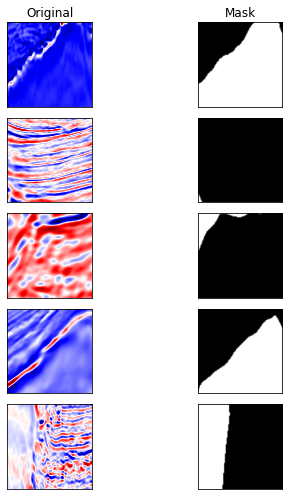

In [5]:
# Get IDs for all samples and randomize order
sample_ids = next(os.walk(os.path.join(data_dir, "images")))[2]

# Randomize sample order
random.shuffle(sample_ids)

# Get number of samples in each set
num_samples = len(sample_ids)
test_data_size = math.floor(num_samples * test_data_ratio)
train_data_size = num_samples - test_data_size

# Split data into training, validation and test set
train_ids = sample_ids[:train_data_size]
test_ids = sample_ids[train_data_size:]

# Load data
train_imgs = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "images", id), 0), (img_size_target, img_size_target))
                       for id in train_ids])
test_imgs = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "images", id), 0), (img_size_target, img_size_target))
                      for id in test_ids])

train_masks = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "masks", id), 0), (img_size_target, img_size_target))
                        for id in train_ids])
test_masks = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "masks", id), 0), (img_size_target, img_size_target))
                       for id in test_ids])

# Add color channel to data and normalize
train_imgs = train_imgs.reshape((len(train_imgs), img_size_target, img_size_target, 1)) / 255.
test_imgs = test_imgs.reshape((len(test_imgs), img_size_target, img_size_target, 1)) / 255.

train_masks = train_masks.reshape((len(train_masks), img_size_target, img_size_target, 1)) / 255.
test_masks = test_masks.reshape((len(test_masks), img_size_target, img_size_target, 1)) / 255.

# Simple Augmentation
train_imgs = np.append(train_imgs, [np.fliplr(x) for x in train_imgs], axis=0)
train_masks = np.append(train_masks, [np.fliplr(x) for x in train_masks], axis=0)

# Visualizing some samples with segmentation
num_samples = 5
shift = 0 # To plot other samples
fig, ax = plt.subplots(num_samples, 2, figsize=(7, 7))
params = {"top": False, "bottom": False, "left": False, "right": False, "labelleft": False,
          "labelbottom": False}

# Set column label color
mpl.rcParams['axes.labelcolor'] = 'w'

ax[0, 0].title.set_text("Original")
ax[0, 1].title.set_text("Mask")

for i in range(0, num_samples):
    ax[i, 0].imshow(train_imgs[i+shift], cmap="seismic")
    ax[i, 0].tick_params(**params)
    ax[i, 1].imshow(train_masks[i+shift], cmap="gray")
    ax[i, 1].tick_params(**params)

plt.tight_layout()
plt.show()

##### Setting up custom segmentation metrics

In [6]:
def iou1class(y_true, y_pred, threshold=0.5):
    ious = []
    for component1, component2 in zip(y_true, y_pred):
        component1 = component1.flatten()
        component2 = (component2.flatten() > threshold) * 1
        overlap = component1 * component2
        union = ((component1 + component2) > 0) * 1
        if (component1 == 0).all() and (component2 == 0).all():
            ious.append(1)
        else:
            ious.append(overlap.sum()/float(union.sum()))

    return np.mean(ious).astype(np.float32)

def IoU(y_true, y_pred):    
    iou = tf.numpy_function(iou1class, [y_true, y_pred], tf.float32)

    return iou

def iou2dice(iou):
    return round((2 * iou) / (1 + iou), 3)

##### Defining the model architecture

In [7]:
def create_unet_model(input_shape):
    input = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), activation="relu", padding="same")(input)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation="relu", padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Bottleneck
    bn = Conv2D(256, 3, activation="relu", padding="same")(pool4)
    bn = Conv2D(256, 3, activation="relu", padding="same")(bn)

    # Decoder
    upconv2 = Conv2DTranspose(128, (2, 2), strides=2, activation="relu", padding="same")(bn)
    upconv2 = concatenate([upconv2, conv4])
    upconv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(upconv2)
    upconv2 = Dropout(0.5)(upconv2)
    upconv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(upconv2)

    upconv3 = Conv2DTranspose(64, (2, 2), strides=2, activation="relu", padding="same")(upconv2)
    upconv3 = concatenate([upconv3, conv3])
    upconv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(upconv3)
    upconv3 = Dropout(0.5)(upconv3)
    upconv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(upconv3)

    upconv4 = Conv2DTranspose(32, (2, 2), strides=2, activation="relu", padding="same")(upconv3)
    upconv4 = concatenate([upconv4, conv2])
    upconv4 = Conv2D(32, (3, 3), activation="relu", padding="same")(upconv4)
    upconv4 = Dropout(0.5)(upconv4)
    upconv4 = Conv2D(32, (3, 3), activation="relu", padding="same")(upconv4)

    upconv5 = Conv2DTranspose(16, (2, 2), strides=2, activation="relu", padding="same")(upconv4)
    upconv5 = concatenate([upconv5, conv1])
    upconv5 = Conv2D(16, (3, 3), activation="relu", padding="same")(upconv5)
    upconv5 = Dropout(0.5)(upconv5)
    upconv5 = Conv2D(16, (3, 3), activation="relu", padding="same")(upconv5)

    output = Conv2D(1, 1, activation="sigmoid")(upconv5)

    return Model(inputs=input, outputs=output)

##### Model preparation and training

In [8]:
# Setup model parameters
model = create_unet_model((img_size_target, img_size_target, 1))
model.compile(optimizer=optimizers.Adam(lr = 0.005), loss="binary_crossentropy", metrics=[IoU])

# Stopping criterion via early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, mode="min", verbose=1)

# Save model at epoch with lowest loss
save_model_name = "unet_weights.hdf5"
model_checkpoint = ModelCheckpoint(save_model_name, 
                                   monitor="loss", 
                                   mode="min", 
                                   save_best_only=True, 
                                   verbose=1)

# Training
train_summary = model.fit(train_imgs, train_masks,
                    validation_split=val_data_ratio,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 0.4533 - IoU: 0.2759
Epoch 00001: loss improved from inf to 0.45329, saving model to unet_weights.hdf5
91/91 [==============================] - 15s 162ms/step - loss: 0.4533 - IoU: 0.2759 - val_loss: 0.6255 - val_IoU: 0.3445
Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 0.3908 - IoU: 0.4896
Epoch 00002: loss improved from 0.45329 to 0.39118, saving model to unet_weights.hdf5
91/91 [==============================] - 13s 145ms/step - loss: 0.3912 - IoU: 0.4897 - val_loss: 0.6578 - val_IoU: 0.2887
Epoch 3/100
90/91 [============================>.] - ETA: 0s - loss: 0.3610 - IoU: 0.5227
Epoch 00003: loss improved from 0.39118 to 0.36154, saving model to unet_weights.hdf5
91/91 [==============================] - 13s 144ms/step - loss: 0.3615 - IoU: 0.5214 - val_loss: 0.8262 - val_IoU: 0.2566
Epoch 4/100
90/91 [============================>.] - ETA: 0s - loss: 0.3356 - IoU: 0.5023
Epoch 00004: loss im

##### Model evaluation

In [9]:
# Evaluation
model = load_model(save_model_name, custom_objects={"IoU": IoU})

loss, mean_iou = model.evaluate(test_imgs, test_masks)
print("Test IoU:", round(mean_iou, 3))
print("Test DICE coefficient:", round((2 * mean_iou) / (1 + mean_iou), 3))

# Plot and save training and validation performances
plot_train_val_performance(train_summary, "IoU")
plot_train_val_performance(train_summary, "loss")

19/19 [==============================] - 1s 38ms/step - loss: 0.1793 - IoU: 0.7144
Test IoU: 0.714
Test DICE coefficient: 0.833
Plot saved as plotly_train_val_IoU_unet.html
Plot saved as plotly_train_val_loss_unet.html


In [10]:
# Format and store performances per epoch for plotting images
train_iou = train_summary.history["IoU"]
val_iou = train_summary.history["val_IoU"]

performance = {epoch: [round(performance[0], 2), round(performance[1], 2)]
               for epoch, performance in enumerate(zip(train_iou, val_iou))}

# Prediction for plotting
pred = model.predict(test_imgs)

# Reshaping images for plotting
test_imgs_plotting = test_imgs.reshape((len(test_imgs), 128, 128))
test_masks_plotting = test_masks.reshape(len(test_masks), 128, 128)
pred_plotting = pred.reshape((len(pred), 128, 128))

# Threshold and dichotomize predictions to yield binary masks
pred_binary = []
for prediction in pred_plotting:  
    transformer = Binarizer(threshold=0.5).fit(prediction)
    pred_binary.append(transformer.transform(prediction))
    
pred_binary = np.array(pred_binary)

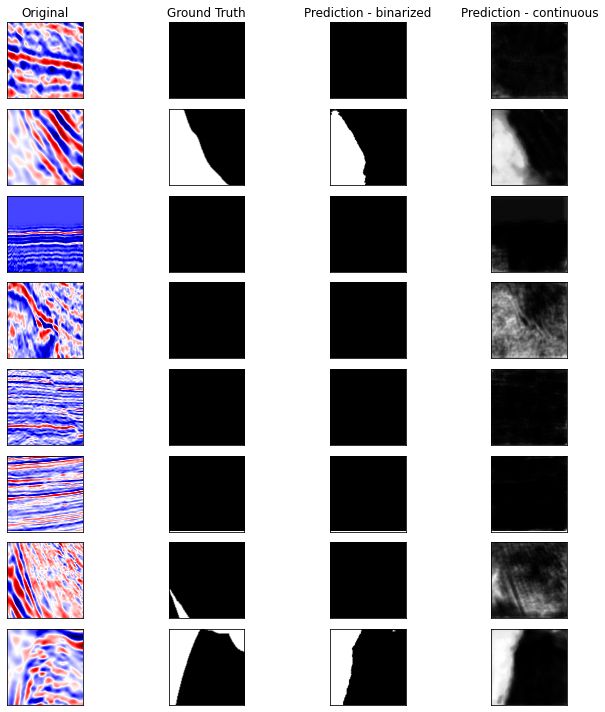

In [11]:
# Visualizing some samples with segmentation
num_samples = 8
shift = 0 # To plot other samples
fig, ax = plt.subplots(num_samples, 4, figsize=(10, 10))

params = {"top": False, "bottom": False, "left": False, "right": False, "labelleft": False,
          "labelbottom": False}

# Set column label color
mpl.rcParams["axes.labelcolor"] = "w"

ax[0, 0].title.set_text("Original")
ax[0, 1].title.set_text("Ground Truth")
ax[0, 2].title.set_text("Prediction - binarized")
ax[0, 3].title.set_text("Prediction - continuous")

for i in range(0, num_samples):
    ax[i, 0].imshow(test_imgs_plotting[i+shift], cmap="seismic")
    ax[i, 0].tick_params(**params)
    ax[i, 1].imshow(test_masks_plotting[i+shift], cmap="gray")
    ax[i, 1].tick_params(**params)
    ax[i, 2].imshow(pred_binary[i+shift], cmap="gray")
    ax[i, 2].tick_params(**params)
    ax[i, 3].imshow(pred_plotting[i+shift], cmap="gray")
    ax[i, 3].tick_params(**params)

plt.tight_layout()
plt.show()

In [12]:
# IoU and DICE at multiple thresholds
test_results = pd.DataFrame(columns=["Threshold", "IoU", "Dice"])

thresholds = np.arange(0, 1, 0.1)
ious = []
dices = []

for i in thresholds:
    iou = iou1class(test_masks, pred, threshold=i)
    ious.append(iou)
    dices.append(iou2dice(iou))

test_results["Threshold"] = thresholds
test_results["IoU"] = np.round(ious, 2)
test_results["Dice"] = np.round(dices, 2)

test_results

,Threshold,IoU,Dice
0,0.0,0.23,0.37
1,0.1,0.40,0.57
2,0.2,0.58,0.73
3,0.3,0.67,0.80
4,0.4,0.70,0.83
5,0.5,0.71,0.83
6,0.6,0.70,0.82
7,0.7,0.67,0.80
8,0.8,0.66,0.79
9,0.9,0.57,0.72


### U-Net with ResNet Blocks
This is a slightly more advanced U-Net architecture incorporating ResNet blocks.
In the following, the U-Net with ResNet blocks is used for the segmentation of the same seismic data set as above.

In [13]:
# Set hyperparameters
num_epochs = 100
batch_size = 16 # Reduce this if you are running out of memory (OOM error when using model.fit())
img_size_target = 101
data_dir = "Seismic_data"

val_data_ratio = 0.15
test_data_ratio = 0.15

##### Data loading and preprocessing

In [14]:
# Get IDs for all samples and randomize order
sample_ids = next(os.walk(os.path.join(data_dir, "images")))[2]

# Randomize sample order
random.shuffle(sample_ids)

# Get number of samples in each set
num_samples = len(sample_ids)
test_data_size = math.floor(num_samples * test_data_ratio)
train_data_size = num_samples - test_data_size

# Split data into training, validation and test set
train_ids = sample_ids[:train_data_size]
test_ids = sample_ids[train_data_size:]

In [15]:
# Load data
train_imgs = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "images", id), 0), (img_size_target, img_size_target))
                       for id in train_ids])
test_imgs = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "images", id), 0), (img_size_target, img_size_target))
                      for id in test_ids])

train_masks = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "masks", id), 0), (img_size_target, img_size_target))
                        for id in train_ids])
test_masks = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "masks", id), 0), (img_size_target, img_size_target))
                       for id in test_ids])

# Add color channel to data and normalize
train_imgs = train_imgs.reshape((len(train_imgs), img_size_target, img_size_target, 1)) / 255.
test_imgs = test_imgs.reshape((len(test_imgs), img_size_target, img_size_target, 1)) / 255.

train_masks = train_masks.reshape((len(train_masks), img_size_target, img_size_target, 1)) / 255.
test_masks = test_masks.reshape((len(test_masks), img_size_target, img_size_target, 1)) / 255.

# Simple Augmentation
train_imgs = np.append(train_imgs, [np.fliplr(x) for x in train_imgs], axis=0)
train_masks = np.append(train_masks, [np.fliplr(x) for x in train_masks], axis=0)

##### Defining the model architecture

In [16]:
def batchactivate(x):
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def convolution_block(x, filters, size, strides=(1, 1), padding="same", activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation is True:
        x = batchactivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = batchactivate(blockInput)
    x = convolution_block(x, num_filters, (3, 3))
    x = convolution_block(x, num_filters, (3, 3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = batchactivate(x)
    return x

In [17]:
def create_uresnet_model(img_shape, start_neurons, dropout_ratio=0.5):
    input_layer = Input(img_shape)

    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout_ratio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout_ratio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout_ratio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_ratio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_ratio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_ratio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(dropout_ratio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(dropout_ratio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return Model(input_layer, output_layer)

##### Model setup and training

In [18]:
# Setup model
model = create_uresnet_model((img_size_target, img_size_target, 1), start_neurons=16)
model.compile(optimizer=optimizers.Adam(lr = 0.005), loss="binary_crossentropy", metrics=[IoU])

# Stopping criterion via early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, mode="min", verbose=1)

# Save model at epoch with lowest loss
save_model_name = "uresnet_weights.hdf5"
model_checkpoint = ModelCheckpoint(save_model_name, 
                                   monitor="loss", 
                                   mode="min", 
                                   save_best_only=True, 
                                   verbose=1)

# Training
train_summary = model.fit(train_imgs, train_masks,
                    validation_split=val_data_ratio,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
362/362 [==============================] - ETA: 0s - loss: 0.4070 - IoU: 0.4690
Epoch 00001: loss improved from inf to 0.40700, saving model to uresnet_weights.hdf5
362/362 [==============================] - 28s 78ms/step - loss: 0.4070 - IoU: 0.4690 - val_loss: 1.4257 - val_IoU: 0.4003
Epoch 2/100
361/362 [============================>.] - ETA: 0s - loss: 0.3148 - IoU: 0.5873
Epoch 00002: loss improved from 0.40700 to 0.31501, saving model to uresnet_weights.hdf5
362/362 [==============================] - 26s 73ms/step - loss: 0.3150 - IoU: 0.5868 - val_loss: 0.4467 - val_IoU: 0.5840
Epoch 3/100
361/362 [============================>.] - ETA: 0s - loss: 0.2928 - IoU: 0.5908
Epoch 00003: loss improved from 0.31501 to 0.29279, saving model to uresnet_weights.hdf5
362/362 [==============================] - 26s 73ms/step - loss: 0.2928 - IoU: 0.5917 - val_loss: 1.0726 - val_IoU: 0.4203
Epoch 4/100
361/362 [============================>.] - ETA: 0s - loss: 0.2628 - IoU: 0.6095


##### Model evaluation

In [19]:
# Evaluation
model = load_model(save_model_name, custom_objects={"IoU": IoU})

loss, mean_iou = model.evaluate(test_imgs, test_masks)
print("Test IoU:", round(mean_iou, 3))
print("Test DICE coefficient:", round((2 * mean_iou) / (1 + mean_iou), 3))

# Plot and save training and validation performances
plot_train_val_performance(train_summary, "IoU")
plot_train_val_performance(train_summary, "loss")

19/19 [==============================] - 1s 49ms/step - loss: 0.1486 - IoU: 0.7812
Test IoU: 0.781
Test DICE coefficient: 0.877
Plot saved as plotly_train_val_IoU_unet.html
Plot saved as plotly_train_val_loss_unet.html


In [20]:
# Format and store performances per epoch for plotting images
train_iou = train_summary.history["IoU"]
val_iou = train_summary.history["val_IoU"]

performance = {epoch: [round(performance[0], 2), round(performance[1], 2)]
               for epoch, performance in enumerate(zip(train_iou, val_iou))}

# Prediction for plotting
pred = model.predict(test_imgs)

# Reshaping images for plotting
test_imgs_plotting = test_imgs.reshape((len(test_imgs), 101, 101))
test_masks_plotting = test_masks.reshape(len(test_masks), 101, 101)
pred_plotting = pred.reshape((len(pred), 101, 101))

# Threshold and dichotomize predictions to yield binary masks
pred_binary = []
for prediction in pred_plotting:  
    transformer = Binarizer(threshold=0.5).fit(prediction)
    pred_binary.append(transformer.transform(prediction))
    
pred_binary = np.array(pred_binary)

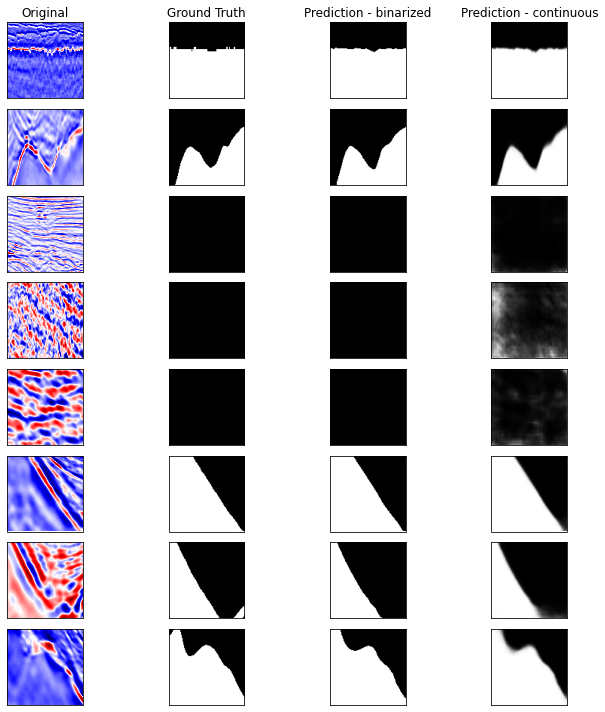

In [21]:
# Visualizing some samples with segmentation
num_samples = 8
shift = 0 # To plot other samples
fig, ax = plt.subplots(num_samples, 4, figsize=(10, 10))

params = {"top": False, "bottom": False, "left": False, "right": False, "labelleft": False,
          "labelbottom": False}

# Set column label color
mpl.rcParams["axes.labelcolor"] = "w"

ax[0, 0].title.set_text("Original")
ax[0, 1].title.set_text("Ground Truth")
ax[0, 2].title.set_text("Prediction - binarized")
ax[0, 3].title.set_text("Prediction - continuous")

for i in range(0, num_samples):
    ax[i, 0].imshow(test_imgs_plotting[i+shift], cmap="seismic")
    ax[i, 0].tick_params(**params)
    ax[i, 1].imshow(test_masks_plotting[i+shift], cmap="gray")
    ax[i, 1].tick_params(**params)
    ax[i, 2].imshow(pred_binary[i+shift], cmap="gray")
    ax[i, 2].tick_params(**params)
    ax[i, 3].imshow(pred_plotting[i+shift], cmap="gray")
    ax[i, 3].tick_params(**params)

plt.tight_layout()
plt.show()

In [22]:
# IoU and DICE at multiple thresholds
test_results = pd.DataFrame(columns=["Threshold", "IoU", "Dice"])

thresholds = np.arange(0, 1, 0.1)
ious = []
dices = []

for i in thresholds:
    iou = iou1class(test_masks, pred, threshold=i)
    ious.append(iou)
    dices.append(iou2dice(iou))

test_results["Threshold"] = thresholds
test_results["IoU"] = np.round(ious, 2)
test_results["Dice"] = np.round(dices, 2)

test_results

,Threshold,IoU,Dice
0,0.0,0.23,0.37
1,0.1,0.57,0.72
2,0.2,0.69,0.82
3,0.3,0.74,0.85
4,0.4,0.77,0.87
5,0.5,0.78,0.88
6,0.6,0.79,0.88
7,0.7,0.78,0.88
8,0.8,0.78,0.88
9,0.9,0.77,0.87
